# SEC Filings

The data is provided in zipped text files. Unzip the file and place the 'SEC-filings' directory into the './data' directory. 

A related dataset in similar format is the conll2003 dataset, available from [HuggingFace](https://huggingface.co/datasets/conll2003). This could be used as a source of additional training data, but note it contains a different kind of text (different 'domain'). 

In [61]:
%load_ext autoreload
%autoreload 2

# Data Extraction
import sys
sys.path.append('..')

import data_loader
import warnings
import functions as f
import params as p
import eli5
import seaborn as sns

# Other
import matplotlib.pyplot as plt
import nltk
from sklearn.exceptions import UndefinedMetricWarning
from sklearn_crfsuite import CRF
from sklearn_crfsuite.metrics import flat_classification_report, flat_f1_score
from sklearn.metrics import make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from collections import Counter

import optuna

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Settings

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action = 'ignore', category = UndefinedMetricWarning)

## Import Data

In [3]:
(
    train_sentences_ner, train_labels_ner, test_sentences_ner, test_labels_ner, val_sentences_ner, val_labels_ner,
    ) = data_loader.import_task2_data()

Loading the original training set: 
Number of sentences loaded = 1152
Number of unique labels: ['I-LOC' 'I-MISC' 'I-ORG' 'I-PER' 'O']

Loading the test set: 
Number of sentences loaded = 303
Number of unique labels: ['I-LOC' 'I-MISC' 'I-ORG' 'I-PER' 'O']


# Task 2 Answer

### Clean Data

In [4]:
def crf_word_preprocessing(word, ref):

    word_features = {
        'bias' : 1.0,
        f'word_{ref}_lower' : word.lower(),
        f'word_{ref}_end3' : word[-3:],
        f'word_{ref}_end2' : word[-2:],
        f'word_{ref}_beg' : word[:3],
        f'word_{ref}_isupper' : word.isupper(),
        f'word_{ref}_istitle' : word.istitle(),
        f'word_{ref}_isdigit' : word.isdigit(),
        f'word_{ref}_postag' : nltk.pos_tag([word])[0][1]
        }

    return word_features

In [5]:
def crf_sentence_preprocessing(sentence):

    sentence_features = []

    for idx in range(len(sentence)):

        word = sentence[idx]

        word_features = crf_word_preprocessing(word, 0)

        if idx > 0:
            word_features = {
                **word_features,
                **crf_word_preprocessing(sentence[idx - 1], -1)
                }
        else:
            word_features['BOS'] = True

        if idx < len(sentence) - 1:
            word_features = {
                **word_features,
                **crf_word_preprocessing(sentence[idx + 1], +1)
            }
        else:
            word_features['EOS'] = True

        sentence_features.append(word_features)

    return sentence_features

In [6]:
def crf_data_preprocessing(data):
    opt = [crf_sentence_preprocessing(sentence) for sentence in data]
    print('data:', len(data), 'out:', len(opt))
    return opt

### Preprocess Data

In [7]:
X_train = crf_data_preprocessing(train_sentences_ner)
X_test = crf_data_preprocessing(test_sentences_ner)
X_val = crf_data_preprocessing(val_sentences_ner)

data: 864 out: 864
data: 303 out: 303
data: 288 out: 288


### NER Modelling

In [8]:
tagger = CRF()
tagger.fit(
    X = X_train,
    y = train_labels_ner,
)

CRF(keep_tempfiles=None)

In [32]:
f.evaluate_model(
    tagger,
    X_train = X_train,
    X_val = X_val,
    y_train = train_labels_ner,
    y_val=val_labels_ner,)

,F1 Score,Accuracy,Precision,Recall
train,0.972331,0.998077,0.998074,0.998077
validation,0.803806,0.986892,0.986346,0.986892


In [10]:
y_pred = tagger.predict(X_val)

In [11]:
labels = list(tagger.classes_)
labels.remove('O')
labels

['I-PER', 'I-ORG', 'I-LOC', 'I-MISC']

In [12]:
print('F1 Score (train):', flat_f1_score(train_labels_ner, tagger.predict(X_train), average='weighted', labels=labels))
print('F1 Score (validation):', flat_f1_score(val_labels_ner, tagger.predict(X_val), average='weighted', labels=labels))

F1 Score (train): 0.9723312699037894
F1 Score (validation): 0.803805870709054


### Tuning

In [13]:
# sampler = optuna.samplers.TPESampler(seed=p.RANDOM_STATE)
# study = optuna.create_study(sampler = sampler, direction = 'maximize', study_name = 'NER_HyperParam_CV')

# oscv_params = {
#     'c2' : optuna.distributions.LogUniformDistribution(1e-4, 1)
# }

# # use the same metric for evaluation
# f1_scorer = make_scorer(
#     score_func = flat_f1_score,
#     average = 'weighted',
#     labels = labels
#     )

# oscv = optuna.integration.OptunaSearchCV(
#     study = study,
#     estimator = CRF(c1 = 1),
#     param_distributions = oscv_params,
#     cv = 10,
#     n_jobs = -1,
#     n_trials = 100,
#     random_state = p.RANDOM_STATE,
#     refit = True,
#     scoring = f1_scorer,
#     verbose = 1
# )

# oscv.fit(X_train, train_labels_ner)

In [14]:
# tuned_crf = oscv.best_estimator_

In [37]:
tuned_crf = CRF(
    c1 = 1,
    c2 = 0.0001
)

tuned_crf.fit(X_train, train_labels_ner)

CRF(c1=1, c2=0.0001, keep_tempfiles=None)

In [96]:
eval_results = f.evaluate_model(
    tuned_crf,
    X_train = X_train,
    X_val = X_val,
    y_train = train_labels_ner,
    y_val = val_labels_ner,
    X_test = X_test,
    y_test = test_labels_ner)

eval_results

,F1 Score,Accuracy,Precision,Recall
Train,0.915037,0.994772,0.977533,0.865922
Validation,0.801679,0.986804,0.882427,0.747807
Test,0.694741,0.985281,0.828885,0.616972


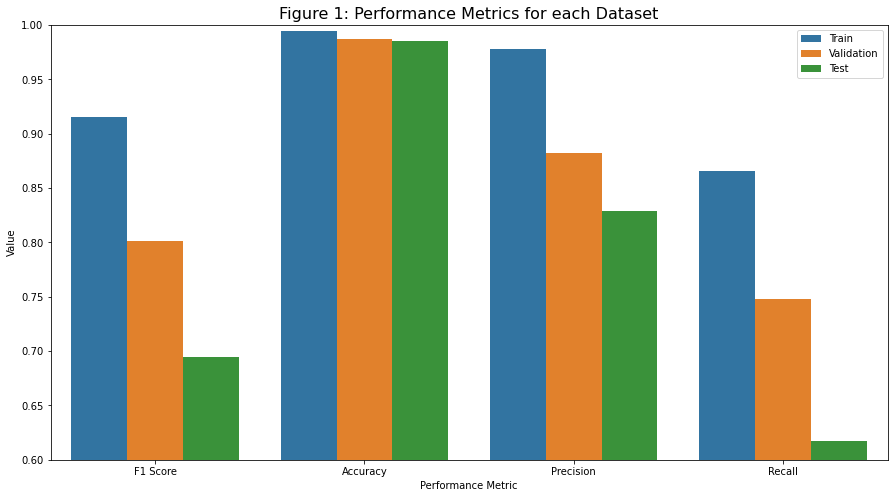

In [101]:
melt_data = eval_results.reset_index().melt(id_vars = 'index')

fig, ax = plt.subplots(1,1,figsize=(15, 8))

sns.barplot(
    ax = ax,
    data = melt_data,
    x = 'variable',
    y = 'value',
    hue = 'index'
).set(label = 'Datasets')

plt.legend(loc = 'upper right')
plt.xlabel('Performance Metric')
plt.ylabel('Value')
plt.ylim(0.6, 1)
plt.title('Figure 1: Performance Metrics for each Dataset', fontsize = 16)
plt.savefig('./final_metrics.png')
plt.show()

### Displaying Results

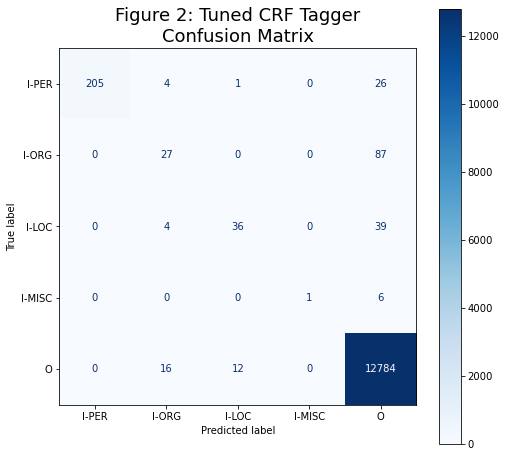

In [113]:
def create_confusion_matrix(y_true, y_pred, ner_labels):

    ner_labels.append('O')

    fig, ax = plt.subplots(1, 1, figsize = (8, 8))

    true = [label for sent_list in y_true for label in sent_list]
    pred = [label for sent_list in y_pred for label in sent_list]

    cm = confusion_matrix(true, pred, ner_labels)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ner_labels)
    disp.plot(cmap = 'Blues', ax = ax)

    plt.title('Figure 2: Tuned CRF Tagger\nConfusion Matrix', fontdict={'fontsize' : 18})

    plt.savefig('./crf_confusion_matrix.png')

    plt.show()

create_confusion_matrix(
    y_pred = tuned_crf.predict(X_test),
    y_true = test_labels_ner,
    ner_labels = labels
)

In [103]:
print(flat_classification_report(
    y_true=test_labels_ner,
    y_pred=tuned_crf.predict(X_test),
    labels = labels
))

              precision    recall  f1-score   support

       I-PER       1.00      0.87      0.93       236
       I-ORG       0.53      0.24      0.33       114
       I-LOC       0.73      0.46      0.56        79
      I-MISC       1.00      0.14      0.25         7

   micro avg       0.88      0.62      0.73       436
   macro avg       0.82      0.43      0.52       436
weighted avg       0.83      0.62      0.69       436



### Eli5

In [81]:
weights_df = eli5.formatters.explain_weights_dfs(tuned_crf, top=5)['transition_features']
weights_df.pivot("from", "to", "coef")

to,I-LOC,I-MISC,I-ORG,I-PER,O
from,,,,,
I-LOC,5.675753,0.0,0.000000,0.000000,-0.005966
I-MISC,0.000000,0.0,0.000000,0.000000,0.000000
I-ORG,0.000000,0.0,5.632606,0.000000,0.032823
I-PER,0.000000,0.0,0.000000,3.533529,0.000000
O,0.000000,0.0,0.000000,0.000000,2.320883


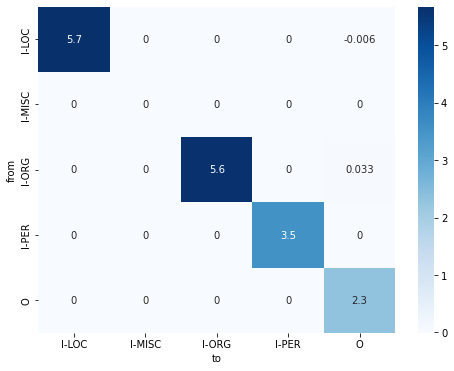

In [90]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
sns.heatmap(ax=ax, data = weights_df.pivot("from", "to", "coef"), annot= True, cmap='Blues')
plt.show()

### Feature Importance

In [1]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("Top positive:")
print_state_features(Counter(tuned_crf.state_features_).most_common(10))

print("\nTop negative:")
print_state_features(Counter(tuned_crf.state_features_).most_common()[-10:])

Top positive:


NameError: name 'Counter' is not defined

## Financial Phrasebank

In [19]:
(train_sentences_fp, test_sentences_fp, val_sentences_fp, train_labels_fp, test_labels_fp, val_labels_fp,
    ) = data_loader.import_task1_data()

sentences_fp = train_sentences_fp + test_sentences_fp + val_sentences_fp
labels_fp = train_labels_fp + test_labels_fp + val_labels_fp

Reusing dataset financial_phrasebank (/Users/jamesstephenson/.cache/huggingface/datasets/financial_phrasebank/sentences_50agree/1.0.0/a6d468761d4e0c8ae215c77367e1092bead39deb08fbf4bffd7c0a6991febbf0)
100%|██████████| 1/1 [00:00<00:00, 30.42it/s]

The dataset is a dictionary with two splits: 

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4846
    })
})
How many instances in the train dataset? 

3876

What does one instance look like? 

`` P&O Ferries now has a very efficient and powerful vessel for its Dover to Calais route , '' head of the shipbuilder 's Rauma yard , Timo Suistio , said .
instances in the validation dataset 

969

instances in the test dataset 

970


### Process Data

In [20]:
def vectorise_data(lst):

    return [nltk.word_tokenize(sentence) for sentence in lst]

In [21]:
sentences_fp = vectorise_data(sentences_fp)

In [22]:
labels_sent_scores = list(map(lambda x: {0: -1, 1: 0, 2: 1}[x], labels_fp))

In [23]:
sentences_fp_pp = crf_data_preprocessing(sentences_fp)

data: 4846 out: 4846


In [24]:
fp_preds = tuned_crf.predict(sentences_fp_pp)

In [25]:
labels = tuned_crf.classes_
labels

['O', 'I-LOC', 'I-PER', 'I-ORG', 'I-MISC']